In [1]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git
%config Completer.use_jedi = False

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439 (from 1)
Receiving objects: 100% (3839/3839), 100.58 MiB | 45.63 MiB/s, done.
Resolving deltas: 100% (10/10), done.


train - 3068 images
val - 341 images
test - 372 images

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras


2025-06-23 13:09:43.770383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750684183.923073      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750684183.965288      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Image

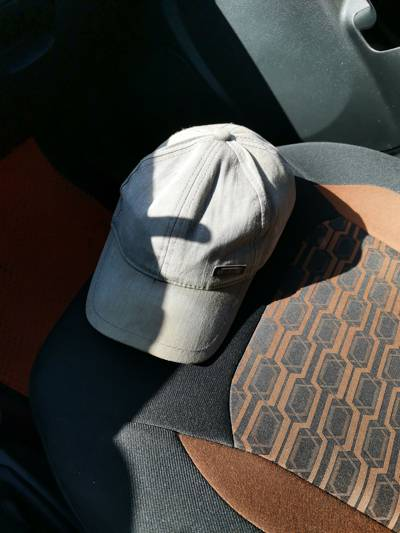

In [3]:
from tensorflow.keras.preprocessing.image import load_img

path = '/kaggle/working/clothing-dataset-small'
one_image = '/train/hat/eb9759ae-a502-438c-b302-3c26761fe921.jpg'
fullImagePath = path + one_image

load_img(fullImagePath)

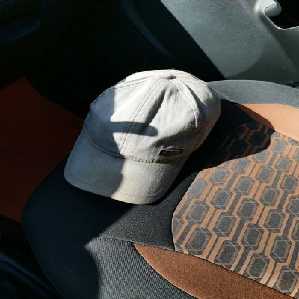

In [4]:
# resize the image
load_img(fullImagePath, target_size=(299,299))

# use pretrained model

In [5]:
from tensorflow.keras.applications.xception import Xception,preprocess_input, decode_predictions


In [6]:
model = Xception(
    weights = 'imagenet',      #use pretrained model
    input_shape = (299,299,3)
)

I0000 00:00:1750684196.419755      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
img = load_img(fullImagePath, target_size=(299,299))   #image object

In [8]:
X = np.array([img])

X.shape

(1, 299, 299, 3)

In [9]:
# prepare the input
X = preprocess_input(X)

In [10]:
X.shape

(1, 299, 299, 3)

In [11]:
# do the predcition
pred = model.predict(X)

I0000 00:00:1750684201.180941     105 service.cc:148] XLA service 0x7bdb0c036850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750684201.181682     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750684201.601787     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1750684203.869825     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
pred.shape

(1, 1000)

In [13]:
pred[0, :10]

array([1.8821447e-04, 1.5743525e-04, 9.5200245e-05, 2.6190581e-05,
       1.2777931e-04, 1.6820381e-04, 3.9163737e-05, 3.6855330e-05,
       5.4871041e-05, 2.1754022e-05], dtype=float32)

In [14]:
# convert prediction to human readable format
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n04162706', 'seat_belt', 0.4836275),
  ('n03530642', 'honeycomb', 0.09660607),
  ('n04591157', 'Windsor_tie', 0.06498071),
  ('n03938244', 'pillow', 0.033908006),
  ('n04350905', 'suit', 0.028448718)]]

# Transfer Learning

In [15]:
train_path = '/kaggle/working/clothing-dataset-small/train'
val_path = '/kaggle/working/clothing-dataset-small/validation'

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
image_size = (150,150)
batch_size =32

In [18]:
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [19]:
train_ds = train_gen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = batch_size
)

Found 3068 images belonging to 10 classes.


In [20]:
# validation dataset
val_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)
val_ds = train_gen.flow_from_directory(
    val_path,
    target_size = image_size,
    batch_size = batch_size
)


Found 341 images belonging to 10 classes.


# Model Creation

In [21]:
base_model  = Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150,150,3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
base_model.trainable = False #freeze the base model to stop being trained

In [23]:
inputs = keras.Input(shape = (150,150,3))   #input images of size 150x150x3

base = base_model(inputs, training=False)       #to extract the high level features

# pooling = keras.layers.GlobalAveragePooling2D()
# vector = pooling(base)
vector = keras.layers.GlobalAveragePooling2D()(base)   #extract the vector  and convert the ouptu  of base to vector

outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs)

# Model Training

In [24]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [25]:
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.5872 - loss: 1.6612 - val_accuracy: 0.7859 - val_loss: 0.7555
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8278 - loss: 0.5394 - val_accuracy: 0.7889 - val_loss: 0.7783
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8959 - loss: 0.2847 - val_accuracy: 0.8123 - val_loss: 0.8458
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9148 - loss: 0.2392 - val_accuracy: 0.7977 - val_loss: 0.8598
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9608 - loss: 0.1122 - val_accuracy: 0.7889 - val_loss: 0.8751
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9637 - loss: 0.1025 - val_accuracy: 0.8182 - val_loss: 0.9105
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9702 - loss: 0.0889 - val_accuracy: 0.7683 - val_loss: 1.1549
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9634 - loss: 0.1072 - val_accuracy: 0.8182 - val_loss: 

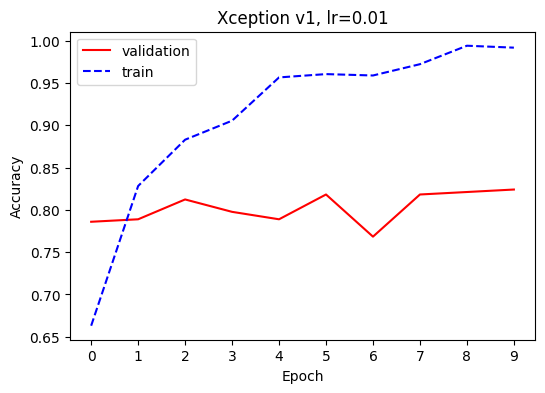

In [27]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='red', linestyle='solid', label='validation')
plt.plot(epochs, train, color='blue', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()

plt.show()

In [28]:
def make_model(lr):
    base_model  = Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150,150,3)
    )
    
    base_model.trainable = False #freeze the base model to stop being trained
    inputs = keras.Input(shape = (150,150,3))   #input images of size 150x150x3

    base = base_model(inputs, training=False)       #to extract the high level features
    vector = keras.layers.GlobalAveragePooling2D()(base)   #extract the vector  and convert the ouptut  of base to vector
    
    outputs = keras.layers.Dense(10)(vector)
    
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy']
    )

    return model

In [29]:
#learning rate = 0.001
model = make_model(0.001)
history_001 = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.4972 - loss: 1.4975 - val_accuracy: 0.7595 - val_loss: 0.7172
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7872 - loss: 0.6401 - val_accuracy: 0.7889 - val_loss: 0.6263
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8394 - loss: 0.5008 - val_accuracy: 0.7977 - val_loss: 0.5882
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8767 - loss: 0.4110 - val_accuracy: 0.8182 - val_loss: 0.5512
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8895 - loss: 0.3615 - val_accuracy: 0.8270 - val_loss: 0.5388
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9179 - loss: 0.3128 - val_accuracy: 0.8182 - val_loss: 0.5324
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9263 - loss: 0.2835 - val_accuracy: 0.8182 - val_loss: 0.5335
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9388 - loss: 0.2481 - val_accuracy: 0.8152 -

In [30]:
#learning rate = 0.0001
model = make_model(0.0001)
history_0001 = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.2475 - loss: 2.2018 - val_accuracy: 0.4927 - val_loss: 1.5722
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5074 - loss: 1.4723 - val_accuracy: 0.6158 - val_loss: 1.2301
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6190 - loss: 1.2321 - val_accuracy: 0.6862 - val_loss: 1.0541
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6758 - loss: 1.0291 - val_accuracy: 0.7126 - val_loss: 0.9442
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7222 - loss: 0.9167 - val_accuracy: 0.7361 - val_loss: 0.8707
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.7251 - loss: 0.8412 - val_accuracy: 0.7419 - val_loss: 0.8212
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7378 - loss: 0.8007 - val_accuracy: 0.7566 - val_loss: 0.7802
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7662 - loss: 0.7555 - val_accuracy: 0.7654 -

In [31]:
def model_plot(history, v,lr):
    plt.figure(figsize=(6, 4))

    epochs = history.epoch
    val = history.history['val_accuracy']
    train = history.history['accuracy']
    
    plt.plot(epochs, val, color='red', linestyle='solid', label='validation')
    plt.plot(epochs, train, color='blue', linestyle='dashed', label='train')
    
    plt.title(f'Xception {v},{lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.xticks(np.arange(10))
    
    plt.legend()
    
    plt.show()

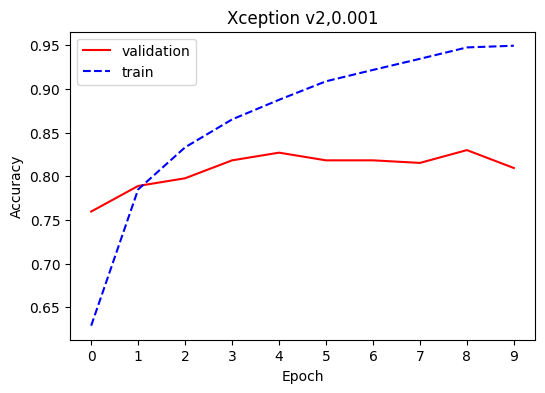

In [32]:
model_plot(history_001, 'v2', 0.001)

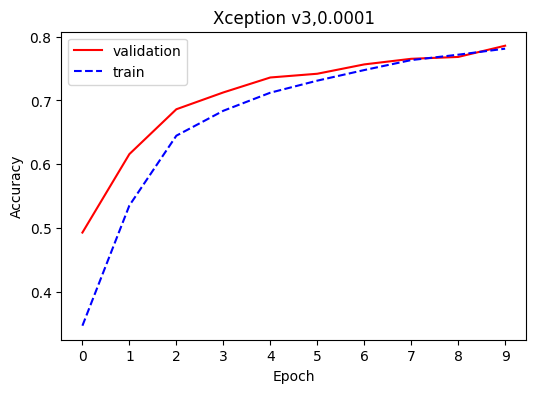

In [33]:
model_plot(history_0001, 'v3', 0.0001)


In [34]:
epochs = np.arange(10)

val_01 = history.history['val_accuracy']
val_001 = history_001.history['val_accuracy']
val_0001 = history_0001.history['val_accuracy']



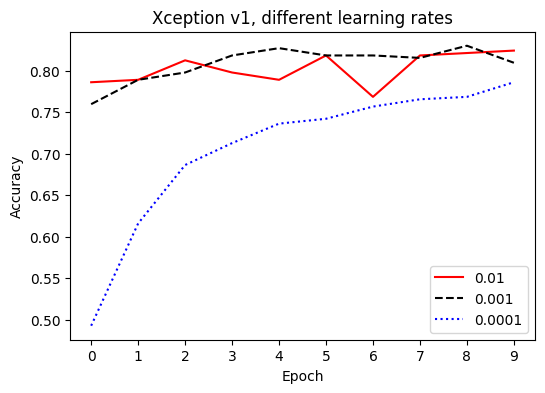

In [35]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_01, color='red', linestyle='solid', label='0.01')
plt.plot(epochs, val_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0001, color='blue', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('xception_v1_all_lr.svg')

plt.show()

1. lr = 0.01 = 0.8211
2. lr -=0.001 = 0.8387
3. lr = 0.0001 = 0.8065 

In [36]:
#save the model

model = make_model(0.001)

In [37]:
checkpoints = [keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    monitor = 'val_accuracy',
    save_best_only = True, 
    mode = 'max'
)]

In [38]:
history_001 = model.fit(
    train_ds, epochs = 10, validation_data = val_ds,
    callbacks = checkpoints
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.5283 - loss: 1.4597 - val_accuracy: 0.7859 - val_loss: 0.6799
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7670 - loss: 0.6763 - val_accuracy: 0.7947 - val_loss: 0.6098
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8331 - loss: 0.5112 - val_accuracy: 0.8123 - val_loss: 0.5737
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8742 - loss: 0.4145 - val_accuracy: 0.8152 - val_loss: 0.5558
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8835 - loss: 0.3634 - val_accuracy: 0.8270 - val_loss: 0.5288
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8967 - loss: 0.3331 - val_accuracy: 0.8270 - val_loss: 0.5363
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9133 - loss: 0.2912 - val_accuracy: 0.8416 - val_loss: 0.5223
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9313 - loss: 0.2555 - val_accuracy: 0.8240 -

# adding inner dense layer


In [41]:
def make_model(lr, droprate):
    base_model  = Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150,150,3)
    )
    
    base_model.trainable = False #freeze the base model to stop being trained
    inputs = keras.Input(shape = (150,150,3))   #input images of size 150x150x3

    base = base_model(inputs, training=False)       #to extract the high level features
    vector = keras.layers.GlobalAveragePooling2D()(base)   #extract the vector  and convert the ouptut  of base to vector
    
    inner = keras.layers.Dense(100, activation = 'relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy']
    )

    return model

## Train the model with drop and inner layer


1. drop =0.0
2. drop = 0.2
3. drop =0.5
4. drop = 0.8

In [42]:
#drop rate =0
model = make_model(0.001, 0.0)

history_0 = model.fit(
    train_ds, epochs = 30, validation_data = val_ds,
    callbacks = checkpoints
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.5698 - loss: 1.2799 - val_accuracy: 0.7918 - val_loss: 0.6377
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8231 - loss: 0.4941 - val_accuracy: 0.8123 - val_loss: 0.5556
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8870 - loss: 0.3508 - val_accuracy: 0.8504 - val_loss: 0.5281
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9190 - loss: 0.2515 - val_accuracy: 0.8446 - val_loss: 0.5244
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9533 - loss: 0.1717 - val_accuracy: 0.8152 - val_loss: 0.5865
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9740 - loss: 0.1245 - val_accuracy: 0.8182 - val_loss: 0.6039
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9841 - loss: 0.0841 - val_accuracy: 0.8211 - val_loss: 0.5705
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9911 - loss: 0.0603 - val_accuracy: 0.8182 -

In [43]:
#drop rate =0
model = make_model(0.001, 0.2)

history_02 = model.fit(
    train_ds, epochs = 30, validation_data = val_ds,
    callbacks = checkpoints
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.5198 - loss: 1.4191 - val_accuracy: 0.7801 - val_loss: 0.6678
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7850 - loss: 0.6328 - val_accuracy: 0.8035 - val_loss: 0.6067
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8453 - loss: 0.4563 - val_accuracy: 0.8182 - val_loss: 0.5694
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8803 - loss: 0.3629 - val_accuracy: 0.8152 - val_loss: 0.5476
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9202 - loss: 0.2688 - val_accuracy: 0.8152 - val_loss: 0.5369
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9346 - loss: 0.2243 - val_accuracy: 0.8094 - val_loss: 0.6011
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9348 - loss: 0.1933 - val_accuracy: 0.8240 - val_loss: 0.5249
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9561 - loss: 0.1682 - val_accuracy: 0.8211 -

In [44]:
#drop rate =0
model = make_model(0.001, 0.5)

history_05 = model.fit(
    train_ds, epochs = 30, validation_data = val_ds,
    callbacks = checkpoints
)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.4742 - loss: 1.5600 - val_accuracy: 0.7507 - val_loss: 0.7506
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7040 - loss: 0.8586 - val_accuracy: 0.8094 - val_loss: 0.6440
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7722 - loss: 0.6565 - val_accuracy: 0.8211 - val_loss: 0.5890
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8035 - loss: 0.5701 - val_accuracy: 0.7977 - val_loss: 0.5759
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8282 - loss: 0.4831 - val_accuracy: 0.8299 - val_loss: 0.5282
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8565 - loss: 0.4320 - val_accuracy: 0.8182 - val_loss: 0.5585
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8587 - loss: 0.3946 - val_accuracy: 0.8240 - val_loss: 0.5286
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8827 - loss: 0.3250 - val_accuracy: 0.8328 -

In [45]:
#drop rate =0
model = make_model(0.001, 0.8)

history_08 = model.fit(
    train_ds, epochs = 30, validation_data = val_ds,
    callbacks = checkpoints
)


Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.3136 - loss: 2.1308 - val_accuracy: 0.6276 - val_loss: 1.1528
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4925 - loss: 1.4295 - val_accuracy: 0.7155 - val_loss: 0.9998
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.5446 - loss: 1.2993 - val_accuracy: 0.7331 - val_loss: 0.8850
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5556 - loss: 1.2172 - val_accuracy: 0.7537 - val_loss: 0.8105
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6085 - loss: 1.1250 - val_accuracy: 0.7595 - val_loss: 0.7487
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5949 - loss: 1.1421 - val_accuracy: 0.7566 - val_loss: 0.7268
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6184 - loss: 1.0618 - val_accuracy: 0.7742 - val_loss: 0.7015
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6173 - loss: 1.0744 - val_accuracy: 0.7713 -

In [46]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_02.history['accuracy']
train05 = history_05.history['accuracy']
train08 = history_08.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_02.history['val_accuracy']
val05 = history_05.history['val_accuracy']
val08 = history_08.history['val_accuracy']

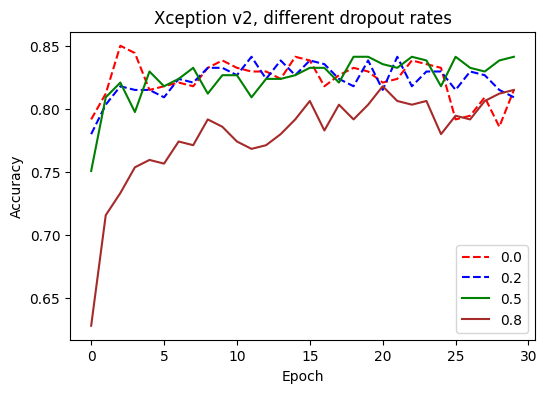

In [47]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='red', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='blue', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='green', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='brown', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

Accuracy
1. 0.0 = 82%
2. 0.2 = 82%
3. 0.5 = 84.16%
4. 0.8 = 81.52%


final parameterds = lr 0.001 dropout rate = 0.5

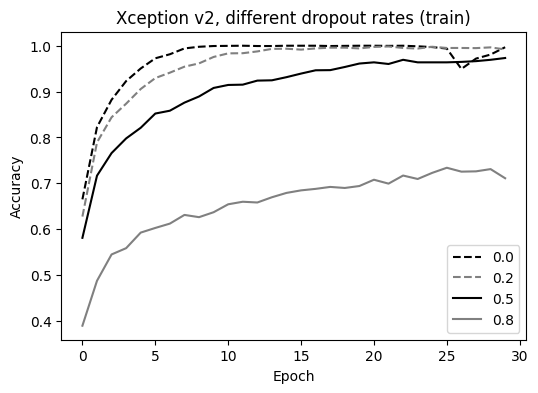

In [48]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

# data augmentation

In [49]:
train_gen = ImageDataGenerator(
    shear_range=10.0,
    zoom_range = 0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [55]:
# train_path, image_size,batch_size

('/kaggle/working/clothing-dataset-small/train', (150, 150), 32)

In [56]:
train_ds = train_gen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = batch_size
)

Found 3068 images belonging to 10 classes.


In [58]:
#validation data
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    val_path,
    target_size = image_size,
    batch_size = batch_size
)

Found 341 images belonging to 10 classes.


In [60]:
#drop rate =0
model = make_model(0.001, 0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(
    train_ds, epochs = 50, validation_data = val_ds,callbacks=callbacks
)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - accuracy: 0.4397 - loss: 1.6844 - val_accuracy: 0.7126 - val_loss: 0.8019
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.6733 - loss: 0.9757 - val_accuracy: 0.7859 - val_loss: 0.6698
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.7406 - loss: 0.7667 - val_accuracy: 0.8152 - val_loss: 0.6050
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.7555 - loss: 0.7131 - val_accuracy: 0.7918 - val_loss: 0.6190
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.7639 - loss: 0.6818 - val_accuracy: 0.8123 - val_loss: 0.5754
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.7719 - loss: 0.6434 - val_accuracy: 0.8211 - val_loss: 0.5637
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.8005 - loss: 0.5762 - val_accuracy: 0.8182 - val_loss: 0.5371
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.8102 - loss: 0.5442 - val_accu

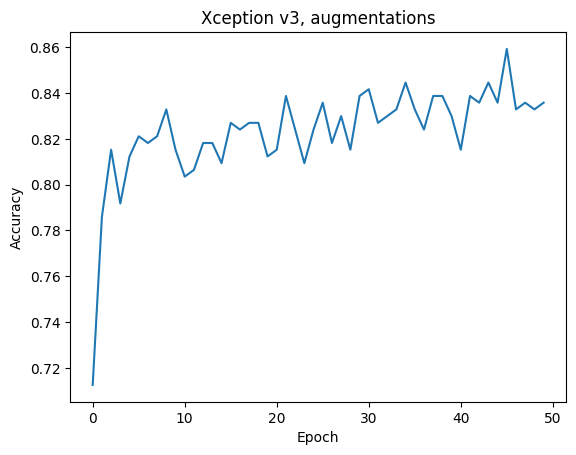

In [64]:
epochs = history.epoch
accuracy = history.history['val_accuracy']


plt.plot(epochs, accuracy)
plt.title('Xception v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# plt.savefig('xception_v3_aug.svg')

plt.show()

In [66]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │         204,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,479,212 (81.94 MB)

 Trainable params: 205,910 (804.34 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 411,822 (1.57 MB)

# Model for larger image(Optional)

In [70]:
def make_model_large(lr, droprate):
    """For larger image size - 299x299x3"""
    base_model  = Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (299,299,3)
    )
    
    base_model.trainable = False #freeze the base model to stop being trained
    inputs = keras.Input(shape = (299,299,3))   #input images of size 150x150x3

    base = base_model(inputs, training=False)       #to extract the high level features
    vector = keras.layers.GlobalAveragePooling2D()(base)   #extract the vector  and convert the ouptut  of base to vector
    
    inner = keras.layers.Dense(100, activation = 'relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(lr)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy']
    )

    return model

In [76]:
image_size=(299,299)
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    train_path,
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    val_path,
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [77]:
model = make_model_large(0.001, 0.5)

In [78]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)          │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 100)                 │         204,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,067,390 (80.37 MB)

 Trainable params: 205,910 (804.34 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [83]:
# For traiing the model
# history_lm = model.fit(train_ds, epochs=10, validation_data=val_ds)
# 

# Test the model

In [84]:
labels = {
    0: 'dress',
    1: 'hat',
    2: 'longsleeve',
    3: 'outwear',
    4: 'pants',
    5: 'shirt',
    6: 'shoes',
    7: 'shorts',
    8: 'skirt',
    9: 't-shirt'
}

In [85]:
image_size = (150,150) #image size

In [87]:
model = keras.models.load_model('/kaggle/working/xception_v3_46_0.859.h5')

In [88]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │         204,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,067,392 (80.37 MB)

 Trainable params: 205,910 (804.34 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 2 (12.00 B)

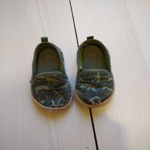

In [128]:
from tensorflow.keras.preprocessing.image import load_img


path = '/kaggle/working/clothing-dataset-small/test/shoes/15120826-cc4c-44d4-8648-7f334bf5fd69.jpg'
img = load_img(path)
img = img.resize((150, 150))
img

#### Preprocess the image

In [129]:
x=np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [130]:
X = preprocess_input(X)

In [131]:
X.shape

(1, 150, 150, 3)

In [132]:
# predict

pred = model.predict(X)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[-20.033064 ,   9.897152 , -12.484221 ,  -9.514019 , -11.960553 ,
         -5.115016 ,  17.046059 , -11.848534 , -13.597733 ,  -7.8079967]],
      dtype=float32)

In [133]:
pred.argmax()

6

In [134]:
labels[pred.argmax()]

'shoes'

In [140]:
def predictClass(path):
    img = load_img(path)
    img = img.resize((150, 150))
    
    X = np.array([np.array(img)])
    pred = model.predict(X)
    return img, labels[pred.argmax()]
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


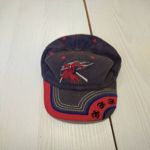

In [153]:
path = '/kaggle/working/clothing-dataset-small/test/hat/a762dfc0-8da7-46d4-9ef1-3c7a085142da.jpg'
img, predictcls = predictClass(path)
img


In [154]:
predictcls

'shoes'

### Ananyse the model accuracy on test data

In [156]:
test_path = '/kaggle/working/clothing-dataset-small/test'

In [157]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    test_path,
    shuffle=False,
    target_size=image_size,
    batch_size=32,
)

Found 372 images belonging to 10 classes.


In [158]:
model.evaluate(test_ds)


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step - accuracy: 0.7072 - loss: 0.8813


[0.6276464462280273, 0.7903226017951965]

The test accuracy is 79% worse than validation and training accucary.

Reason : Becuase dataset is not too large and we have used smalleer size images.